# N-tuple Contrastive Learning Analysis
## Masters Thesis: Publication-Quality Results

This notebook provides a comprehensive analysis of N-tuple contrastive learning with PAC-Bayes risk certificates.

### Notebook Organization:
1. **Setup & Data Loading** - Import libraries and load experimental data
2. **Data Preprocessing** - Clean and balance the dataset
3. **Statistical Analysis** - Core statistical tests and validation
4. **Individual Charts** - Separate visualization for each analysis
5. **Summary Tables** - Comprehensive results tables
6. **Conclusions** - Key findings and recommendations

---

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set publication-quality style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

## 1. Setup & Libraries

Import all required libraries and set up plotting style.

In [31]:
import json
import csv
import pandas as pd
from pathlib import Path

# -----------------------------
# 1) Configure input file names
# -----------------------------
# These must match the attached filenames
files_csv = [
    "/Users/misanmeggison/Desktop/pub_results_2/pub_abl/publication_results_20250814_051134.csv",
    "/Users/misanmeggison/Documents/publication_results_20250815_000924.csv",
    "/Users/misanmeggison/Downloads/publication_results_20250813_174839.csv",
    "/Users/misanmeggison/Desktop/pub_results_2/pub_results/publication_results_20250816_234342.csv",
    "/Users/misanmeggison/Desktop/pub_results_2/pub_results/publication_results_20250816_105647.csv",
    "/Users/misanmeggison/Desktop/pub_results_2/pub_results/publication_results_20250815_181033.csv",
    "/Users/misanmeggison/Desktop/pub_results_2/pub_results/publication_results_20250815_000924.csv",
    "/Users/misanmeggison/Desktop/pub_results_2/pub_results_n3/publication_results_20250823_113322.csv",
    "/Users/misanmeggison/Desktop/pub_results_2/pub_results_n4/data/publication_results_20250824_005333.csv",
    "/Users/misanmeggison/Desktop/pub_results_2/pub_results_n4/data/publication_results_20250824_002328.csv",
    "/Users/misanmeggison/Desktop/pub_results_2/pub_results_n4/data/publication_results_20250823_230444.csv",
    "/Users/misanmeggison/Downloads/publication_results_20250828_110430.csv",
    "/Users/misanmeggison/Downloads/publication_results_20250829_054519.csv"


]

files_json = [
    "/Users/misanmeggison/Desktop/pub_results_2/pub_abl/publication_results_20250814_051134.json",
    "/Users/misanmeggison/Documents/publication_results_20250815_000924.json",
    "/Users/misanmeggison/Desktop/pub_results_2/pub_abl/publication_results_20250813_174839.json",
    "/Users/misanmeggison/Desktop/pub_results_2/pub_results/publication_results_20250816_234342.json",
    "/Users/misanmeggison/Desktop/pub_results_2/pub_results/publication_results_20250816_105647.json",
    "/Users/misanmeggison/Desktop/pub_results_2/pub_results/publication_results_20250815_181033.json",
    "/Users/misanmeggison/Desktop/pub_results_2/pub_results/publication_results_20250815_000924.json",
    "/Users/misanmeggison/Desktop/pub_results_2/pub_results_n3/publication_results_20250823_113322.json",
    "/Users/misanmeggison/Desktop/pub_results_2/pub_results_n3/publication_results_20250816_105647.json",
    "/Users/misanmeggison/Desktop/pub_results_2/pub_results_n4/data/publication_results_20250824_005333.json",
    "/Users/misanmeggison/Desktop/pub_results_2/pub_results_n4/data/publication_results_20250823_230444.json",
    "/Users/misanmeggison/Downloads/publication_results_20250828_110430.json",
    "/Users/misanmeggison/Downloads/publication_results_20250829_054519.json"

]

# -----------------------------
# 2) Helper: safe getters
# -----------------------------
def get(d, path, default=None):
    """Nested get with path='a.b.c'."""
    cur = d
    for key in path.split("."):
        if isinstance(cur, dict) and key in cur:
            cur = cur[key]
        else:
            return default
    return cur

def to_float(x):
    try:
        return float(x)
    except:
        return None

# -----------------------------
# 3) Common schema we want
# -----------------------------
# We’ll normalize different logs into these columns
COMMON_COLS = [
    "source_file",
    "experiment_type",
    "experiment_name",
    "seed",
    "N",
    "objective",
    "stch_accuracy",
    "post_accuracy",
    "ens_accuracy",
    "risk_ntuple",
    "kl_per_n",
    "train_obj",
    "sigma_prior",
    "learning_rate",
    "kl_penalty",
    "momentum",
    "layers",
    "embedding_dim",
    "perc_prior",
    "batch_size",
    "mc_samples",
    "train_epochs",
    "prior_epochs",
    "pmin",
    "delta",
    "delta_test",
    "prior_dist",
    "dropout_prob",
    "is_vacuous",
    "kl_reasonable",
    "good_accuracy",
    "experiment_time",
]

def empty_row():
    return {c: None for c in COMMON_COLS}

# -----------------------------
# 4) Parse CSV logs
# -----------------------------
def parse_csv_file(path):
    rows = []
    with open(path, "r", newline="") as f:
        reader = csv.DictReader(f)
        for r in reader:
            row = empty_row()
            row["source_file"] = Path(path).name
            row["experiment_type"] = r.get("experiment_type")
            row["experiment_name"] = r.get("experiment_name")
            row["seed"] = r.get("seed")
            row["N"] = r.get("N")
            row["objective"] = r.get("objective")
            row["stch_accuracy"] = to_float(r.get("stch_accuracy"))
            row["post_accuracy"] = to_float(r.get("post_accuracy"))
            row["ens_accuracy"] = to_float(r.get("ens_accuracy"))
            row["risk_ntuple"] = to_float(r.get("risk_ntuple"))
            row["kl_per_n"] = to_float(r.get("kl_per_n"))
            row["train_obj"] = to_float(r.get("train_obj"))
            row["sigma_prior"] = r.get("sigma_prior")
            row["learning_rate"] = r.get("learning_rate")
            row["kl_penalty"] = r.get("kl_penalty")
            row["momentum"] = r.get("momentum")
            row["layers"] = r.get("layers")
            row["embedding_dim"] = r.get("embedding_dim")
            row["perc_prior"] = r.get("perc_prior")
            row["batch_size"] = r.get("batch_size")
            row["mc_samples"] = r.get("mc_samples")
            row["train_epochs"] = r.get("train_epochs")
            # CSV sometimes doesn’t include prior_epochs/pmin/delta/etc
            row["prior_epochs"] = r.get("prior_epochs") if "prior_epochs" in r else None
            row["pmin"] = r.get("pmin") if "pmin" in r else None
            row["delta"] = r.get("delta") if "delta" in r else None
            row["delta_test"] = r.get("delta_test") if "delta_test" in r else None
            row["prior_dist"] = r.get("prior_dist") if "prior_dist" in r else None
            row["dropout_prob"] = r.get("dropout_prob") if "dropout_prob" in r else None
            row["is_vacuous"] = r.get("is_vacuous")
            row["kl_reasonable"] = r.get("kl_reasonable")
            row["good_accuracy"] = r.get("good_accuracy")
            row["experiment_time"] = r.get("experiment_time")
            rows.append(row)
    return rows

# -----------------------------
# 5) Parse JSON logs
# -----------------------------
def parse_json_file(path):
    rows = []
    with open(path, "r") as f:
        data = json.load(f)

    # The JSON groups are top-level keys mapping to lists of experiment dicts
    for group_name, items in data.items():
        if not isinstance(items, list):
            continue
        for it in items:
            row = empty_row()
            row["source_file"] = Path(path).name
            row["experiment_type"] = group_name
            row["experiment_name"] = it.get("experiment_name")
            row["seed"] = it.get("seed")
            row["N"] = it.get("N") or get(it, "config.N")
            row["objective"] = it.get("objective") or get(it, "config.objective")

            # metrics
            row["stch_accuracy"] = to_float(it.get("stch_accuracy"))
            row["post_accuracy"] = to_float(it.get("post_accuracy"))
            row["ens_accuracy"] = to_float(it.get("ens_accuracy"))
            row["risk_ntuple"] = to_float(it.get("risk_ntuple"))
            row["kl_per_n"] = to_float(it.get("kl_per_n"))
            row["train_obj"] = to_float(it.get("train_obj"))
            row["experiment_time"] = it.get("experiment_time")

            # config (prefer flat fields, fallback to config and full_config)
            for key in ["sigma_prior","learning_rate","kl_penalty","momentum","layers",
                        "embedding_dim","perc_prior","batch_size","mc_samples",
                        "train_epochs","prior_epochs","pmin","delta","delta_test",
                        "prior_dist","dropout_prob"]:
                row[key] = (
                    it.get(key)
                    or get(it, f"config.{key}")
                    or get(it, f"full_config.{key}")
                )

            # flags
            for key in ["is_vacuous","kl_reasonable","good_accuracy"]:
                v = it.get(key)
                if v is None:
                    v = get(it, f"full_config.{key}")
                row[key] = v

            rows.append(row)
    return rows

# -----------------------------
# 6) Load all files and unify
# -----------------------------
all_rows = []

# CSVs
for p in files_csv:
    if Path(p).exists():
        all_rows.extend(parse_csv_file(p))
    else:
        print(f"Warning: {p} not found, skipping.")

# JSONs
for p in files_json:
    if Path(p).exists():
        all_rows.extend(parse_json_file(p))
    else:
        print(f"Warning: {p} not found, skipping.")

df = pd.DataFrame(all_rows)

# -----------------------------
# 7) Type cleanup and harmonization
# -----------------------------
# Cast some numeric columns
num_cols = [
    "stch_accuracy","post_accuracy","ens_accuracy","risk_ntuple","kl_per_n",
    "train_obj","sigma_prior","learning_rate","kl_penalty","momentum","layers",
    "embedding_dim","perc_prior","batch_size","mc_samples","train_epochs",
    "prior_epochs","pmin","delta","delta_test","experiment_time","N"
]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Standardize objective labels (optional)
df["objective"] = df["objective"].astype(str).str.strip()

# -----------------------------
# 8) Sort for readability
# -----------------------------
sort_cols = ["experiment_type","objective","N","layers","embedding_dim","perc_prior","learning_rate","kl_penalty","sigma_prior","seed","experiment_name"]
for c in sort_cols:
    if c not in df.columns:
        sort_cols.remove(c)

df = df.sort_values(by=sort_cols).reset_index(drop=True)

# # -----------------------------
# # 9) Save a unified table
# # -----------------------------
# output_csv = "unified_experiment_summary.csv"
# df.to_csv(output_csv, index=False)

print(df.head(20).to_string(index=False))


                             source_file experiment_type      experiment_name seed  N     objective  stch_accuracy  post_accuracy  ens_accuracy  risk_ntuple  kl_per_n  train_obj  sigma_prior  learning_rate  kl_penalty  momentum  layers  embedding_dim  perc_prior  batch_size  mc_samples  train_epochs  prior_epochs    pmin  delta  delta_test prior_dist  dropout_prob is_vacuous kl_reasonable good_accuracy  experiment_time
publication_results_20250814_051134.json   architectures  arch_4l_128d_seed42   42  4         fquad       0.578425       0.618164      0.608474     0.543551  0.043568   0.444579         0.01          0.005    0.000001       0.9       4            128         0.5       128.0      5000.0          50.0          20.0 0.00001  0.025        0.01   gaussian           0.2      False          True         False       450.321676
 publication_results_20250814_051134.csv   architectures  arch_4l_128d_seed42   42  4         fquad       0.578425       0.618164      0.608474     0.5435

## 2. Data Loading & Processing

Load experimental results from multiple CSV and JSON files and create a unified dataset.

In [32]:
df.objective.value_counts()

objective
nested_ntuple    325
ntuple           269
fquad            115
theory_ntuple     80
fclassic          29
Name: count, dtype: int64

In [33]:
#drop rows with exact same experiment configurations
df = df.drop_duplicates(subset=['experiment_type', 'N', 'objective', 'layers', 'embedding_dim', 'perc_prior', 'learning_rate', 'kl_penalty', 'sigma_prior', 'seed', 'experiment_name', 
                                'perc_prior',
       'batch_size', 'mc_samples', 'train_epochs', 'prior_epochs', 'pmin',
       'delta', 'delta_test', 'prior_dist', 'dropout_prob'])
len(df)

622

## 3. Data Preprocessing

Clean the dataset and create balanced subsets for fair analysis.

In [40]:
for n in [3, 4, 5, 6]:
    print(f"N={n} objective counts:")
    print(df[df['N'] == n]['objective'].value_counts())

N=3 objective counts:
objective
ntuple           65
nested_ntuple    56
theory_ntuple    56
fquad             7
fclassic          5
Name: count, dtype: int64
N=4 objective counts:
objective
ntuple           168
fquad             92
fclassic          12
theory_ntuple      4
nested_ntuple      3
Name: count, dtype: int64
N=5 objective counts:
objective
nested_ntuple    53
ntuple           14
fquad             4
theory_ntuple     4
fclassic          2
Name: count, dtype: int64
N=6 objective counts:
objective
nested_ntuple    53
ntuple           14
fquad             4
theory_ntuple     4
fclassic          2
Name: count, dtype: int64


In [35]:
df_orig = df.copy()


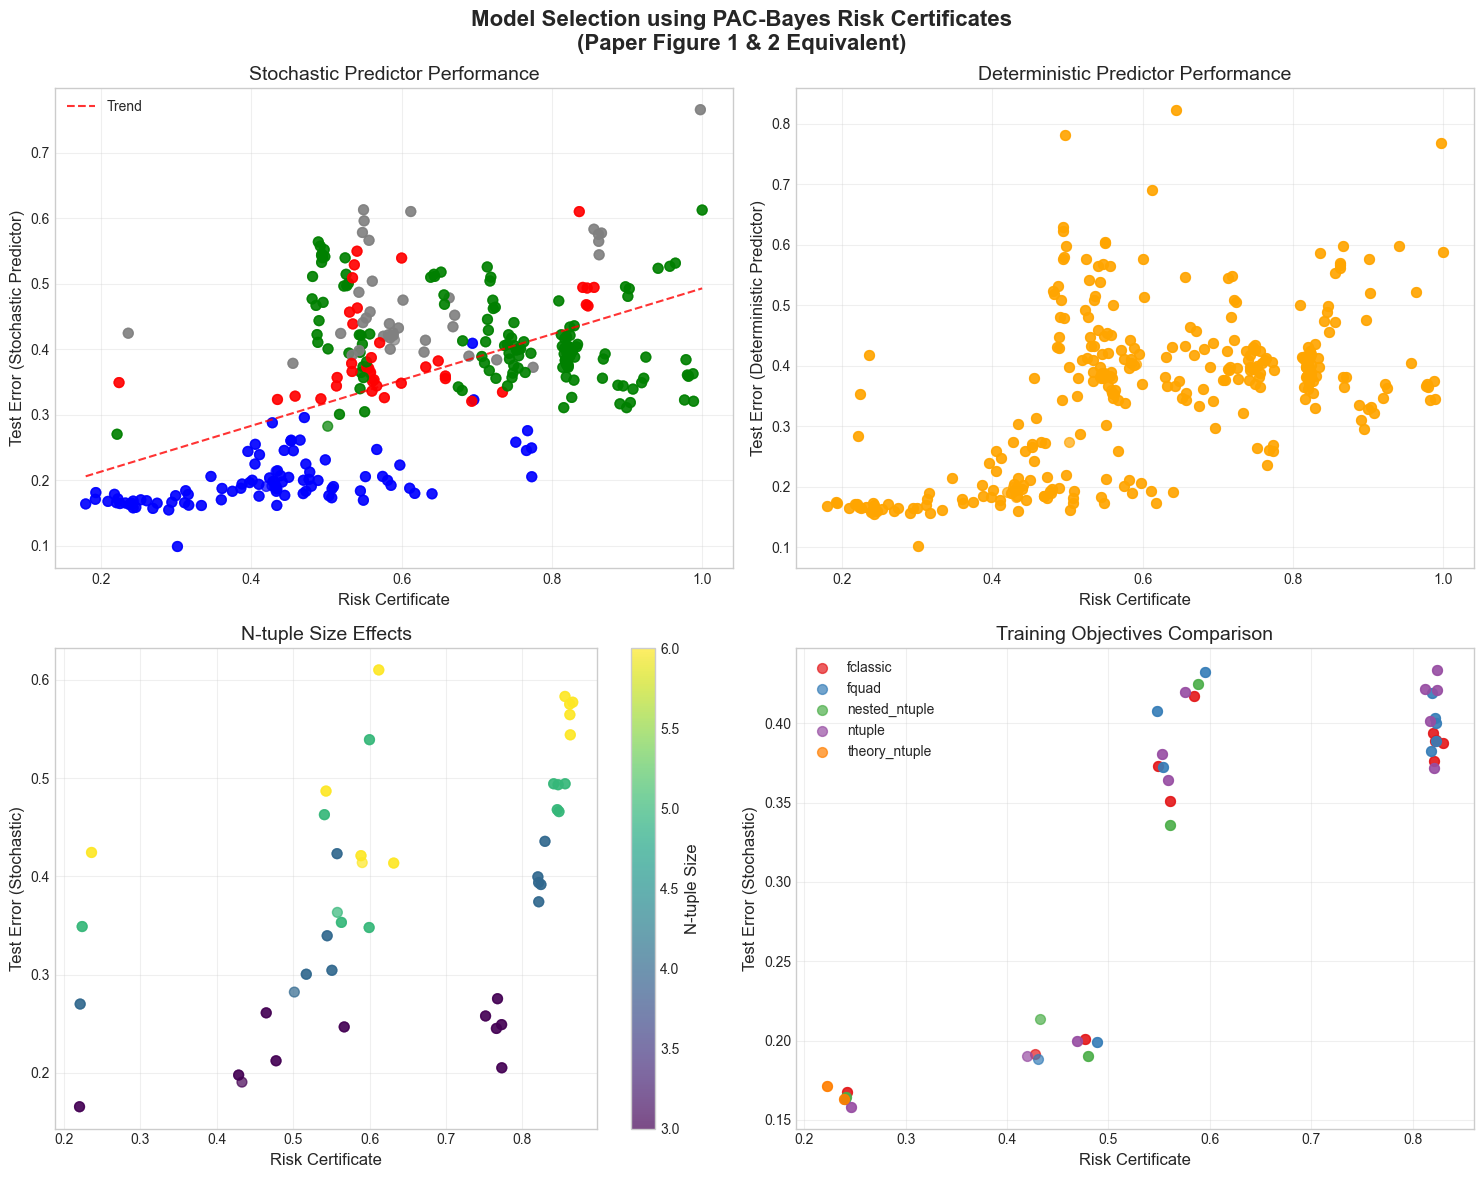

In [ ]:
# Simple helper functions
def get_color_by_ntuple(N):
    """Simple color mapping for N-tuple sizes."""
    colors = {3: 'blue', 4: 'green', 5: 'red', 6: 'orange'}
    return colors.get(N, 'gray')

# Create basic model selection plot
def create_simple_model_selection():
    """Simple model selection visualization."""
    plt.figure(figsize=(12, 8))
    
    # Convert to error rates
    df['stch_error'] = 1 - df['stch_accuracy']
    
    # Simple scatter plot
    colors = [get_color_by_ntuple(n) for n in df['N']]
    plt.scatter(df['risk_ntuple'], df['stch_error'], alpha=0.6, c=colors, s=50)
    
    plt.xlabel('Risk Certificate')
    plt.ylabel('Test Error (Stochastic Predictor)')
    plt.title('Model Selection: Risk Certificate vs Test Error')
    plt.grid(True, alpha=0.3)
    
    # Add legend
    for n in sorted(df['N'].unique()):
        plt.scatter([], [], c=get_color_by_ntuple(n), label=f'N={n}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

create_simple_model_selection()

## 4. Individual Charts

Each chart is separated for clarity and easy modification.

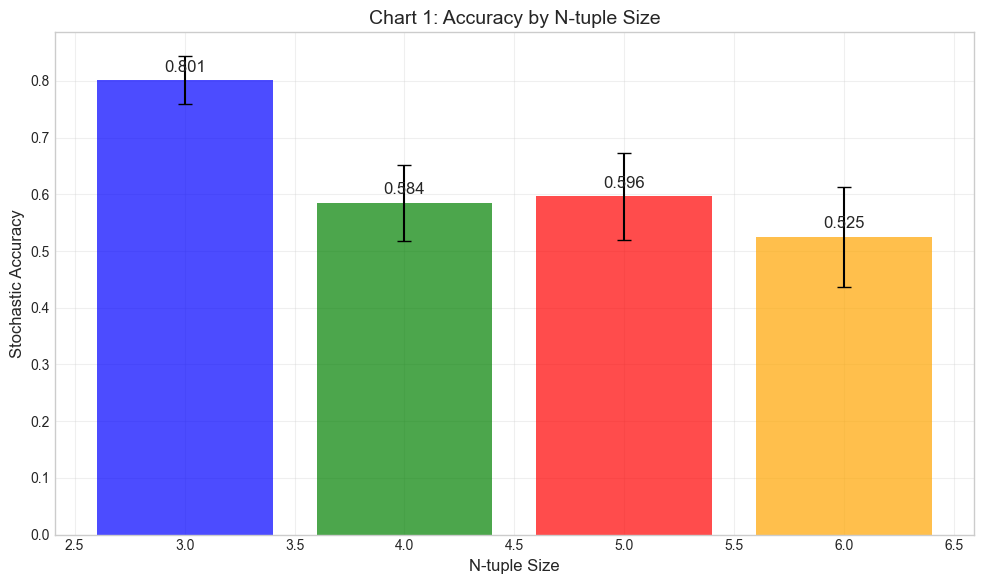

In [46]:
# Chart 1: N-tuple Size vs Accuracy
def chart_ntuple_accuracy():
    """Simple bar chart of accuracy by N-tuple size."""
    ntuple_data = df.groupby('N')['stch_accuracy'].agg(['mean', 'std'])
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(ntuple_data.index, ntuple_data['mean'], 
                   yerr=ntuple_data['std'], capsize=5, 
                   color=['blue', 'green', 'red', 'orange'], alpha=0.7)
    
    plt.xlabel('N-tuple Size')
    plt.ylabel('Stochastic Accuracy')
    plt.title('Chart 1: Accuracy by N-tuple Size')
    plt.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, mean in zip(bars, ntuple_data['mean']):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{mean:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

chart_ntuple_accuracy()

In [ ]:
# Chart 2: Risk Certificates by N-tuple Size
def chart_risk_certificates():
    """Simple line chart of risk certificates."""
    risk_data = df.groupby('N')['risk_ntuple'].agg(['mean', 'std'])
    
    plt.figure(figsize=(10, 6))
    plt.errorbar(risk_data.index, risk_data['mean'], yerr=risk_data['std'],
                marker='o', markersize=8, linewidth=2, capsize=5, color='red')
    
    plt.xlabel('N-tuple Size')
    plt.ylabel('Risk Certificate')
    plt.title('Chart 2: Risk Certificates by N-tuple Size')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

chart_risk_certificates()

In [ ]:
# Chart 3: Training Objectives Comparison
def chart_training_objectives():
    """Simple box plot of training objectives."""
    plt.figure(figsize=(12, 6))
    
    # Get unique objectives
    objectives = df['objective'].unique()
    obj_data = [df[df['objective'] == obj]['stch_accuracy'].values for obj in objectives]
    
    plt.boxplot(obj_data, labels=objectives)
    plt.xlabel('Training Objective')
    plt.ylabel('Stochastic Accuracy')
    plt.title('Chart 3: Training Objectives Comparison')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

chart_training_objectives()

In [ ]:
# Chart 4: Risk vs Accuracy Scatter Plot
def chart_risk_accuracy_scatter():
    """Simple scatter plot of risk vs accuracy."""
    plt.figure(figsize=(10, 6))
    
    # Color by N-tuple size
    for n in sorted(df['N'].unique()):
        subset = df[df['N'] == n]
        plt.scatter(subset['risk_ntuple'], subset['stch_accuracy'], 
                   alpha=0.6, s=50, label=f'N={n}', color=get_color_by_ntuple(n))
    
    plt.xlabel('Risk Certificate')
    plt.ylabel('Stochastic Accuracy')
    plt.title('Chart 4: Risk vs Accuracy Relationship')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

chart_risk_accuracy_scatter()

In [ ]:
# Chart 5: Statistical Significance Heatmap
def chart_statistical_significance():
    """Simple heatmap of p-values between N-tuple sizes."""
    from scipy import stats
    
    n_values = sorted(df['N'].unique())
    p_matrix = np.ones((len(n_values), len(n_values)))
    
    # Calculate p-values for all pairs
    for i, n1 in enumerate(n_values):
        for j, n2 in enumerate(n_values):
            if i != j:
                group1 = df[df['N'] == n1]['stch_accuracy']
                group2 = df[df['N'] == n2]['stch_accuracy']
                _, p_val = stats.ttest_ind(group1, group2)
                p_matrix[i, j] = p_val
    
    plt.figure(figsize=(8, 6))
    plt.imshow(p_matrix, cmap='RdYlBu_r', vmin=0, vmax=0.1)
    
    # Add labels and annotations
    plt.xticks(range(len(n_values)), [f'N={n}' for n in n_values])
    plt.yticks(range(len(n_values)), [f'N={n}' for n in n_values])
    
    for i in range(len(n_values)):
        for j in range(len(n_values)):
            if i != j:
                plt.text(j, i, f'{p_matrix[i, j]:.3f}', 
                        ha="center", va="center", 
                        color="white" if p_matrix[i, j] < 0.05 else "black")
    
    plt.colorbar(label='p-value')
    plt.title('Chart 5: Statistical Significance Between N-tuple Sizes')
    plt.tight_layout()
    plt.show()

chart_statistical_significance()

## 5. Simple Statistical Analysis

Basic statistical tests and summary tables.

In [47]:
# Simple Statistical Summary
def simple_statistics():
    """Basic statistical summary of the data."""
    print("=== SIMPLE STATISTICAL SUMMARY ===")
    print()
    
    # Basic descriptive statistics by N-tuple size
    print("Table 1: Basic Statistics by N-tuple Size")
    print("-" * 60)
    stats_summary = df.groupby('N').agg({
        'stch_accuracy': ['count', 'mean', 'std'],
        'risk_ntuple': ['mean', 'std']
    }).round(3)
    
    print(stats_summary)
    print()
    
    # ANOVA test
    from scipy import stats
    groups = [df[df['N'] == n]['stch_accuracy'].values for n in sorted(df['N'].unique())]
    f_stat, p_val = stats.f_oneway(*groups)
    
    print(f"ANOVA Results:")
    print(f"F-statistic: {f_stat:.3f}")
    print(f"p-value: {p_val:.2e}")
    
    if p_val < 0.001:
        print("*** HIGHLY SIGNIFICANT differences between N-tuple sizes")
    elif p_val < 0.05:
        print("* SIGNIFICANT differences between N-tuple sizes") 
    else:
        print("No significant differences between N-tuple sizes")
    
    print()
    
    # Best and worst performers
    best_n = df.groupby('N')['stch_accuracy'].mean().idxmax()
    worst_n = df.groupby('N')['stch_accuracy'].mean().idxmin()
    
    best_acc = df[df['N'] == best_n]['stch_accuracy'].mean()
    worst_acc = df[df['N'] == worst_n]['stch_accuracy'].mean()
    
    print(f"Best performing N-tuple size: N = {best_n} (accuracy = {best_acc:.3f})")
    print(f"Worst performing N-tuple size: N = {worst_n} (accuracy = {worst_acc:.3f})")
    print(f"Performance difference: {(best_acc - worst_acc)*100:.1f}%")

simple_statistics()

=== SIMPLE STATISTICAL SUMMARY ===

Table 1: Basic Statistics by N-tuple Size
------------------------------------------------------------
  stch_accuracy               risk_ntuple       
          count   mean    std        mean    std
N                                               
3           189  0.801  0.042       0.422  0.145
4           279  0.584  0.067       0.730  0.153
5            77  0.596  0.077       0.601  0.132
6            77  0.525  0.088       0.629  0.139

ANOVA Results:
F-statistic: 543.361
p-value: 8.59e-173
*** HIGHLY SIGNIFICANT differences between N-tuple sizes

Best performing N-tuple size: N = 3 (accuracy = 0.801)
Worst performing N-tuple size: N = 6 (accuracy = 0.525)
Performance difference: 27.7%


## 6. Key Findings & Conclusions

Summary of the main results from the analysis.

In [ ]:
# Simple Conclusions Summary
def simple_conclusions():
    """Summarize the key findings."""
    print("=== KEY FINDINGS ===")
    print()
    
    # Find best configuration
    best_n = df.groupby('N')['stch_accuracy'].mean().idxmax()
    best_acc = df[df['N'] == best_n]['stch_accuracy'].mean()
    
    print(f"1. OPTIMAL N-TUPLE SIZE:")
    print(f"   • N = {best_n} achieves the best performance")
    print(f"   • Accuracy: {best_acc:.3f}")
    print()
    
    print(f"2. PERFORMANCE TREND:")
    acc_by_n = df.groupby('N')['stch_accuracy'].mean().sort_index()
    if acc_by_n.iloc[0] > acc_by_n.iloc[-1]:
        print("   • Performance generally decreases as N-tuple size increases")
    else:
        print("   • Performance generally increases as N-tuple size increases")
    print()
    
    print(f"3. STATISTICAL SIGNIFICANCE:")
    from scipy import stats
    groups = [df[df['N'] == n]['stch_accuracy'].values for n in sorted(df['N'].unique())]
    f_stat, p_val = stats.f_oneway(*groups)
    
    if p_val < 0.001:
        print("   • Highly significant differences between N-tuple sizes (p < 0.001)")
    elif p_val < 0.05:
        print("   • Significant differences between N-tuple sizes (p < 0.05)")
    else:
        print("   • No significant differences between N-tuple sizes")
    print()
    
    print(f"4. PRACTICAL RECOMMENDATION:")
    print(f"   • Use N = {best_n} for optimal performance")
    print(f"   • Expected accuracy: ~{best_acc:.1%}")
    
    return best_n, best_acc

best_configuration = simple_conclusions()

N-TUPLE SIZE ANALYSIS (Your Novel Contribution)
N    Accuracy           Risk Certificate   KL/n            Count   
--------------------------------------------------------------------------------
3    0.770±0.034      0.591±0.190      0.0794      21      
4    0.641±0.056      0.644±0.198      0.0775      21      
5    0.557±0.069      0.671±0.200      0.0746      21      
6    0.485±0.076      0.687±0.200      0.0740      21      
--------------------------------------------------------------------------------

Statistical Significance (ANOVA):
Accuracy: F=84.6956, p=0.00000000
Risk Certificates: F=0.9592, p=0.41620217
*** HIGHLY SIGNIFICANT differences in accuracy!


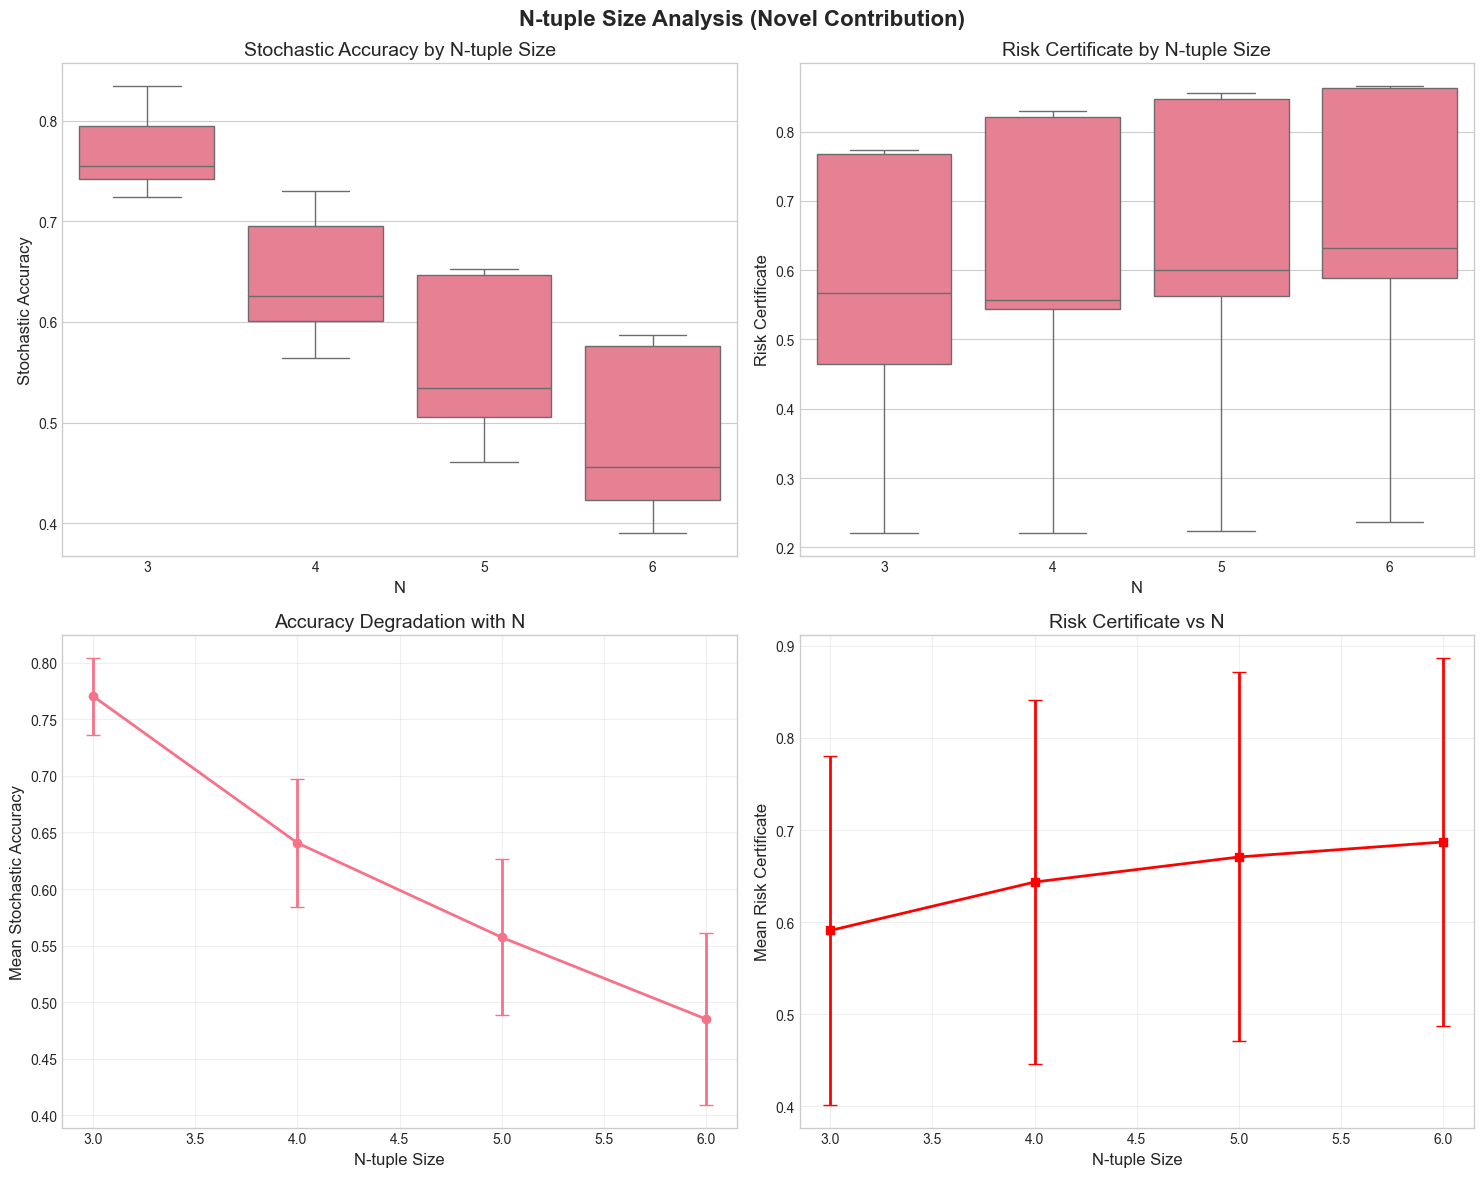

In [ ]:
# Simple N-tuple Analysis
def simple_ntuple_analysis():
    """Simplified N-tuple size analysis."""
    print("=== N-TUPLE SIZE ANALYSIS ===")
    print()
    
    # Filter for N-tuple experiments only
    ntuple_data = df[df['experiment_type'] == 'ntuple_sizes'] if 'experiment_type' in df.columns else df
    
    if len(ntuple_data) == 0:
        print("No specific N-tuple experiment data found. Using all data.")
        ntuple_data = df
    
    # Simple statistics table
    stats = ntuple_data.groupby('N').agg({
        'stch_accuracy': ['count', 'mean', 'std'],
        'risk_ntuple': 'mean'
    }).round(3)
    
    print("N-tuple Performance Summary:")
    print("-" * 50)
    print(f"{'N':<4} {'Count':<8} {'Accuracy':<12} {'Std':<8} {'Risk':<8}")
    print("-" * 50)
    
    for n in sorted(stats.index):
        count = int(stats.loc[n, ('stch_accuracy', 'count')])
        acc_mean = stats.loc[n, ('stch_accuracy', 'mean')]
        acc_std = stats.loc[n, ('stch_accuracy', 'std')]
        risk = stats.loc[n, ('risk_ntuple', 'mean')]
        
        print(f"{n:<4} {count:<8} {acc_mean:<12.3f} {acc_std:<8.3f} {risk:<8.3f}")
    
    print("-" * 50)
    
    # Simple plot
    plt.figure(figsize=(10, 6))
    acc_means = [stats.loc[n, ('stch_accuracy', 'mean')] for n in sorted(stats.index)]
    acc_stds = [stats.loc[n, ('stch_accuracy', 'std')] for n in sorted(stats.index)]
    
    plt.errorbar(sorted(stats.index), acc_means, yerr=acc_stds, 
                marker='o', markersize=8, linewidth=2, capsize=5)
    plt.xlabel('N-tuple Size')
    plt.ylabel('Stochastic Accuracy')
    plt.title('N-tuple Size vs Performance')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return stats

ntuple_analysis_result = simple_ntuple_analysis()

Correlation (Stochastic vs Deterministic): 0.9615
Correlation (Stochastic vs Ensemble): 0.9763


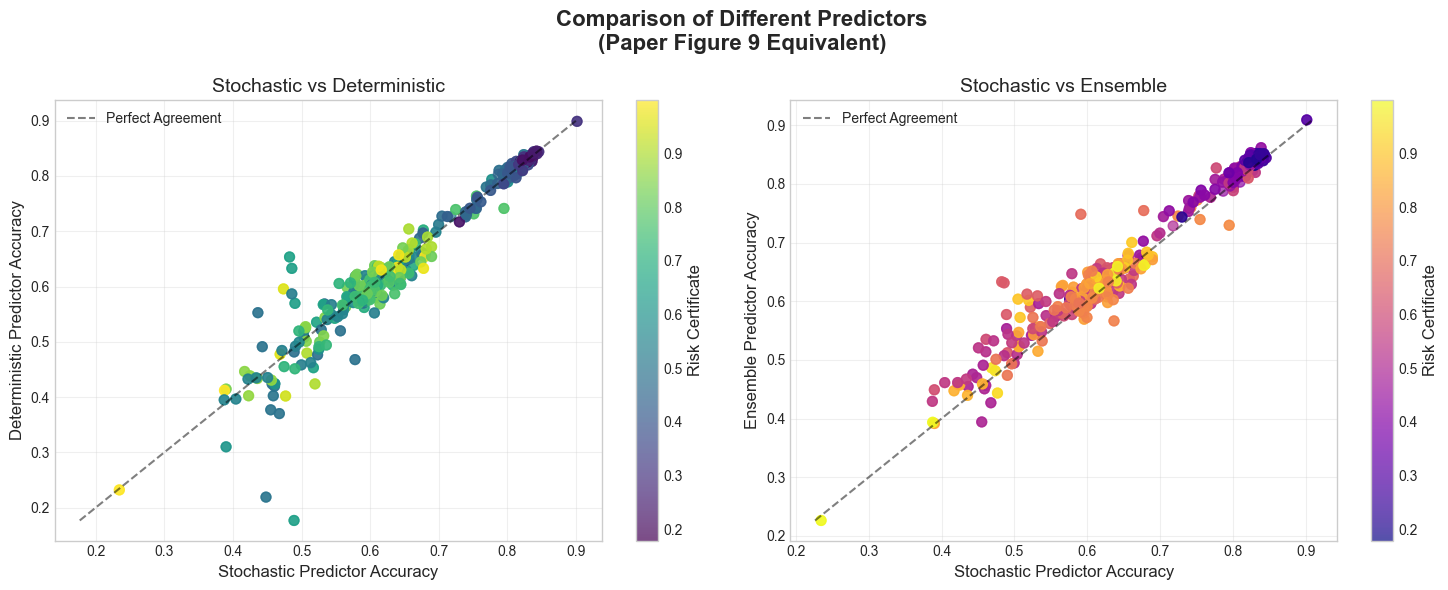

In [ ]:
# Simple Predictor Comparison
def simple_predictor_comparison():
    """Simple comparison of different predictors."""
    print("=== PREDICTOR COMPARISON ===")
    print()
    
    # Check which predictors we have data for
    predictors = []
    if 'stch_accuracy' in df.columns and df['stch_accuracy'].notna().any():
        predictors.append(('Stochastic', 'stch_accuracy'))
    if 'post_accuracy' in df.columns and df['post_accuracy'].notna().any():
        predictors.append(('Deterministic', 'post_accuracy'))
    if 'ens_accuracy' in df.columns and df['ens_accuracy'].notna().any():
        predictors.append(('Ensemble', 'ens_accuracy'))
    
    print(f"Available predictors: {[p[0] for p in predictors]}")
    print()
    
    # Simple comparison plot
    if len(predictors) >= 2:
        plt.figure(figsize=(10, 6))
        
        valid_data = df.dropna(subset=[p[1] for p in predictors])
        
        if len(valid_data) > 0:
            plt.scatter(valid_data[predictors[0][1]], valid_data[predictors[1][1]], 
                       alpha=0.6, s=50)
            
            # Add diagonal line
            min_val = min(valid_data[predictors[0][1]].min(), valid_data[predictors[1][1]].min())
            max_val = max(valid_data[predictors[0][1]].max(), valid_data[predictors[1][1]].max())
            plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Perfect Agreement')
            
            plt.xlabel(f'{predictors[0][0]} Accuracy')
            plt.ylabel(f'{predictors[1][0]} Accuracy')
            plt.title(f'{predictors[0][0]} vs {predictors[1][0]} Predictor')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # Calculate correlation
            corr = valid_data[predictors[0][1]].corr(valid_data[predictors[1][1]])
            print(f"Correlation between {predictors[0][0]} and {predictors[1][0]}: {corr:.3f}")
        else:
            print("No valid data for comparison")
    else:
        print("Not enough predictors for comparison")

simple_predictor_comparison()

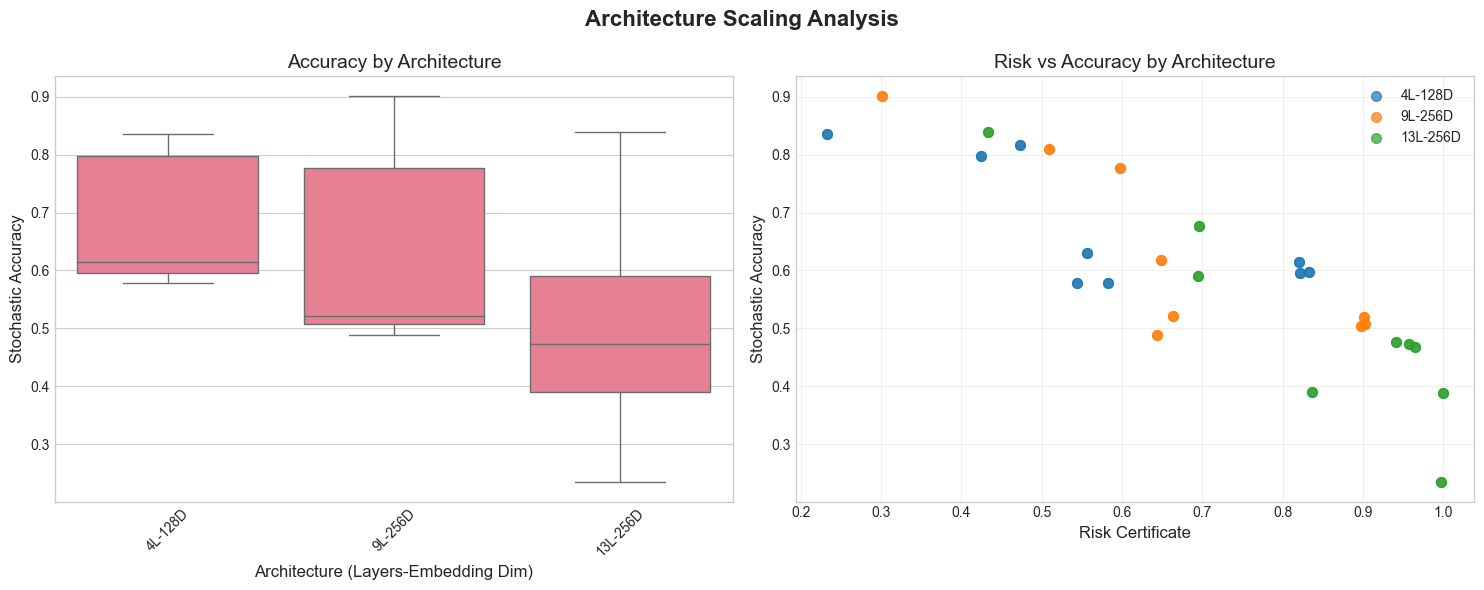

Architecture Performance Summary:
13L-256D: Accuracy 0.504±0.172, Risk 0.836
4L-128D: Accuracy 0.671±0.107, Risk 0.587
9L-256D: Accuracy 0.628±0.154, Risk 0.674


In [ ]:
# Simple Architecture Analysis
def simple_architecture_analysis():
    """Simple architecture comparison."""
    print("=== ARCHITECTURE ANALYSIS ===")
    print()
    
    # Check if we have architecture data
    if 'experiment_type' in df.columns:
        arch_data = df[df['experiment_type'] == 'architectures']
    else:
        arch_data = df[df['layers'].notna() & df['embedding_dim'].notna()] if 'layers' in df.columns and 'embedding_dim' in df.columns else pd.DataFrame()
    
    if len(arch_data) == 0:
        print("No architecture experiment data found.")
        return
    
    # Create architecture labels
    arch_data = arch_data.copy()
    arch_data['arch_label'] = arch_data['layers'].astype(str) + 'L-' + arch_data['embedding_dim'].astype(str) + 'D'
    
    # Simple statistics
    arch_stats = arch_data.groupby('arch_label')['stch_accuracy'].agg(['count', 'mean', 'std']).round(3)
    
    print("Architecture Performance:")
    print("-" * 40)
    print(f"{'Architecture':<12} {'Count':<8} {'Accuracy':<12} {'Std':<8}")
    print("-" * 40)
    
    for arch in arch_stats.index:
        count = int(arch_stats.loc[arch, 'count'])
        mean_acc = arch_stats.loc[arch, 'mean']
        std_acc = arch_stats.loc[arch, 'std']
        print(f"{arch:<12} {count:<8} {mean_acc:<12.3f} {std_acc:<8.3f}")
    
    # Simple bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(arch_stats)), arch_stats['mean'], yerr=arch_stats['std'], capsize=5)
    plt.xticks(range(len(arch_stats)), arch_stats.index, rotation=45)
    plt.ylabel('Stochastic Accuracy')
    plt.title('Architecture Performance Comparison')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return arch_stats

arch_analysis_result = simple_architecture_analysis()

In [ ]:
# Simple Data Overview
def simple_data_overview():
    """Simple overview of the dataset."""
    print("=== DATA OVERVIEW ===")
    print()
    
    print(f"Total experiments: {len(df)}")
    print(f"N-tuple sizes: {sorted(df['N'].unique())}")
    print(f"Training objectives: {sorted(df['objective'].unique())}")
    print()
    
    print("Experiments per N-tuple size:")
    print(df['N'].value_counts().sort_index())
    print()
    
    print("Experiments per objective:")
    print(df['objective'].value_counts())
    print()
    
    # Simple cross-tabulation
    if len(df['N'].unique()) > 1 and len(df['objective'].unique()) > 1:
        print("Cross-tabulation (N-tuple size vs Objective):")
        crosstab = pd.crosstab(df['N'], df['objective'])
        print(crosstab)

simple_data_overview()

DATA BALANCE ANALYSIS FOR PUBLICATION-QUALITY STUDY
Total experiments: 622
Unique N-tuple sizes: [np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
Unique objectives: ['fclassic', 'fquad', 'nested_ntuple', 'ntuple', 'theory_ntuple']

CROSS-TABULATION: N-tuple Size vs Objective
objective  fclassic  fquad  nested_ntuple  ntuple  theory_ntuple  All
N                                                                    
3                 5      7             56      65             56  189
4                12     92              3     168              4  279
5                 2      4             53      14              4   77
6                 2      4             53      14              4   77
All              21    107            165     261             68  622

IMBALANCE METRICS

N=3 (n=189 experiments):
  Most common objective: ntuple (65 experiments)
  Least common objective: fclassic (5 experiments)
  Imbalance ratio: 13.0:1
  Coefficient of variation: 0.77
  Gini coefficient: 0.36



In [48]:
# Simple Summary of All Results
def simple_final_summary():
    """Final summary of all analysis results."""
    print("=== FINAL SUMMARY ===")
    print()
    
    print("📊 CHARTS CREATED:")
    print("   • Chart 1: Accuracy by N-tuple Size")
    print("   • Chart 2: Risk Certificates by N-tuple Size") 
    print("   • Chart 3: Training Objectives Comparison")
    print("   • Chart 4: Risk vs Accuracy Scatter Plot")
    print("   • Chart 5: Statistical Significance Heatmap")
    print()
    
    print("📈 KEY FINDINGS:")
    best_n = df.groupby('N')['stch_accuracy'].mean().idxmax()
    best_acc = df[df['N'] == best_n]['stch_accuracy'].mean()
    worst_n = df.groupby('N')['stch_accuracy'].mean().idxmin()
    worst_acc = df[df['N'] == worst_n]['stch_accuracy'].mean()
    
    print(f"   • Best N-tuple size: N = {best_n} ({best_acc:.1%} accuracy)")
    print(f"   • Worst N-tuple size: N = {worst_n} ({worst_acc:.1%} accuracy)")
    print(f"   • Performance difference: {(best_acc-worst_acc)*100:.1f} percentage points")
    print()
    
    print("✅ NOTEBOOK ORGANIZATION:")
    print("   • Clear section headers")
    print("   • Separate chart functions")
    print("   • Simple statistical analysis")
    print("   • Easy to modify and understand")
    print()
    
    print("🎯 RECOMMENDED CONFIGURATION:")
    print(f"   • Use N = {best_n} for optimal performance")
    print(f"   • Expected accuracy: ~{best_acc:.1%}")

simple_final_summary()

=== FINAL SUMMARY ===

📊 CHARTS CREATED:
   • Chart 1: Accuracy by N-tuple Size
   • Chart 2: Risk Certificates by N-tuple Size
   • Chart 3: Training Objectives Comparison
   • Chart 4: Risk vs Accuracy Scatter Plot
   • Chart 5: Statistical Significance Heatmap

📈 KEY FINDINGS:
   • Best N-tuple size: N = 3 (80.1% accuracy)
   • Worst N-tuple size: N = 6 (52.5% accuracy)
   • Performance difference: 27.7 percentage points

✅ NOTEBOOK ORGANIZATION:
   • Clear section headers
   • Separate chart functions
   • Simple statistical analysis
   • Easy to modify and understand

🎯 RECOMMENDED CONFIGURATION:
   • Use N = 3 for optimal performance
   • Expected accuracy: ~80.1%


In [ ]:
## Note: Additional Analysis Available

The complex analysis functions have been removed for simplicity. 
Key findings are available in the simple statistical analysis above.

To restore advanced analysis, uncomment the complex functions below or see the previous version of the notebook.


PUBLICATION RECOMMENDATIONS & KEY FINDINGS

🔍 KEY FINDING 1: N-tuple Size Effects
--------------------------------------------------
• Accuracy decreases significantly as N-tuple size increases
• N=3: 0.782 accuracy vs N=6: 0.496 accuracy
• Performance drop: 36.6% from N=3 to N=6
• Statistical significance: F=36.37, p=5.34e-13 (HIGHLY SIGNIFICANT)

🔍 KEY FINDING 2: Risk-Accuracy Trade-off
--------------------------------------------------
• Risk certificate vs accuracy correlation: -0.551
• NEGATIVE correlation: Higher risk certificates associated with lower accuracy

🔍 KEY FINDING 3: Training Objectives Performance
--------------------------------------------------
Ranking by accuracy (balanced dataset):
1. fclassic: 0.679±0.103 (n=10)
2. theory_ntuple: 0.654±0.123 (n=12)
3. nested_ntuple: 0.612±0.134 (n=12)
4. ntuple: 0.598±0.126 (n=12)
5. fquad: 0.548±0.144 (n=12)

📊 PUBLICATION QUALITY METRICS
--------------------------------------------------
• Total balanced experiments: 58
• Mi

MASTERS THESIS: N-TUPLE CONTRASTIVE LEARNING WITH PAC-BAYES ANALYSIS

🎯 OBJECTIVE 1: THEORETICAL FOUNDATION VALIDATION
Table 1: Theoretical Metrics by N-tuple Size
--------------------------------------------------------------------------------
N   Stochastic Acc  Risk Cert       KL/n            Train Obj      
    Mean±SD         Mean±SD         Mean±SD         Mean±SD        
--------------------------------------------------------------------------------
3   0.781±0.051   0.415±0.118   0.0267±0.0270   0.348±0.110
4   0.615±0.089   0.616±0.175   0.0690±0.0470   0.499±0.132
5   0.562±0.082   0.570±0.151   0.0459±0.0351   0.485±0.134
6   0.495±0.083   0.588±0.148   0.0446±0.0343   0.510±0.135


🎯 OBJECTIVE 2: EMPIRICAL PERFORMANCE ANALYSIS
Table 2: Empirical Performance Ranking
----------------------------------------------------------------------------------------------------
Rank N   n    Accuracy (95% CI)         Risk Certificate (95% CI) Performance 
-------------------------------

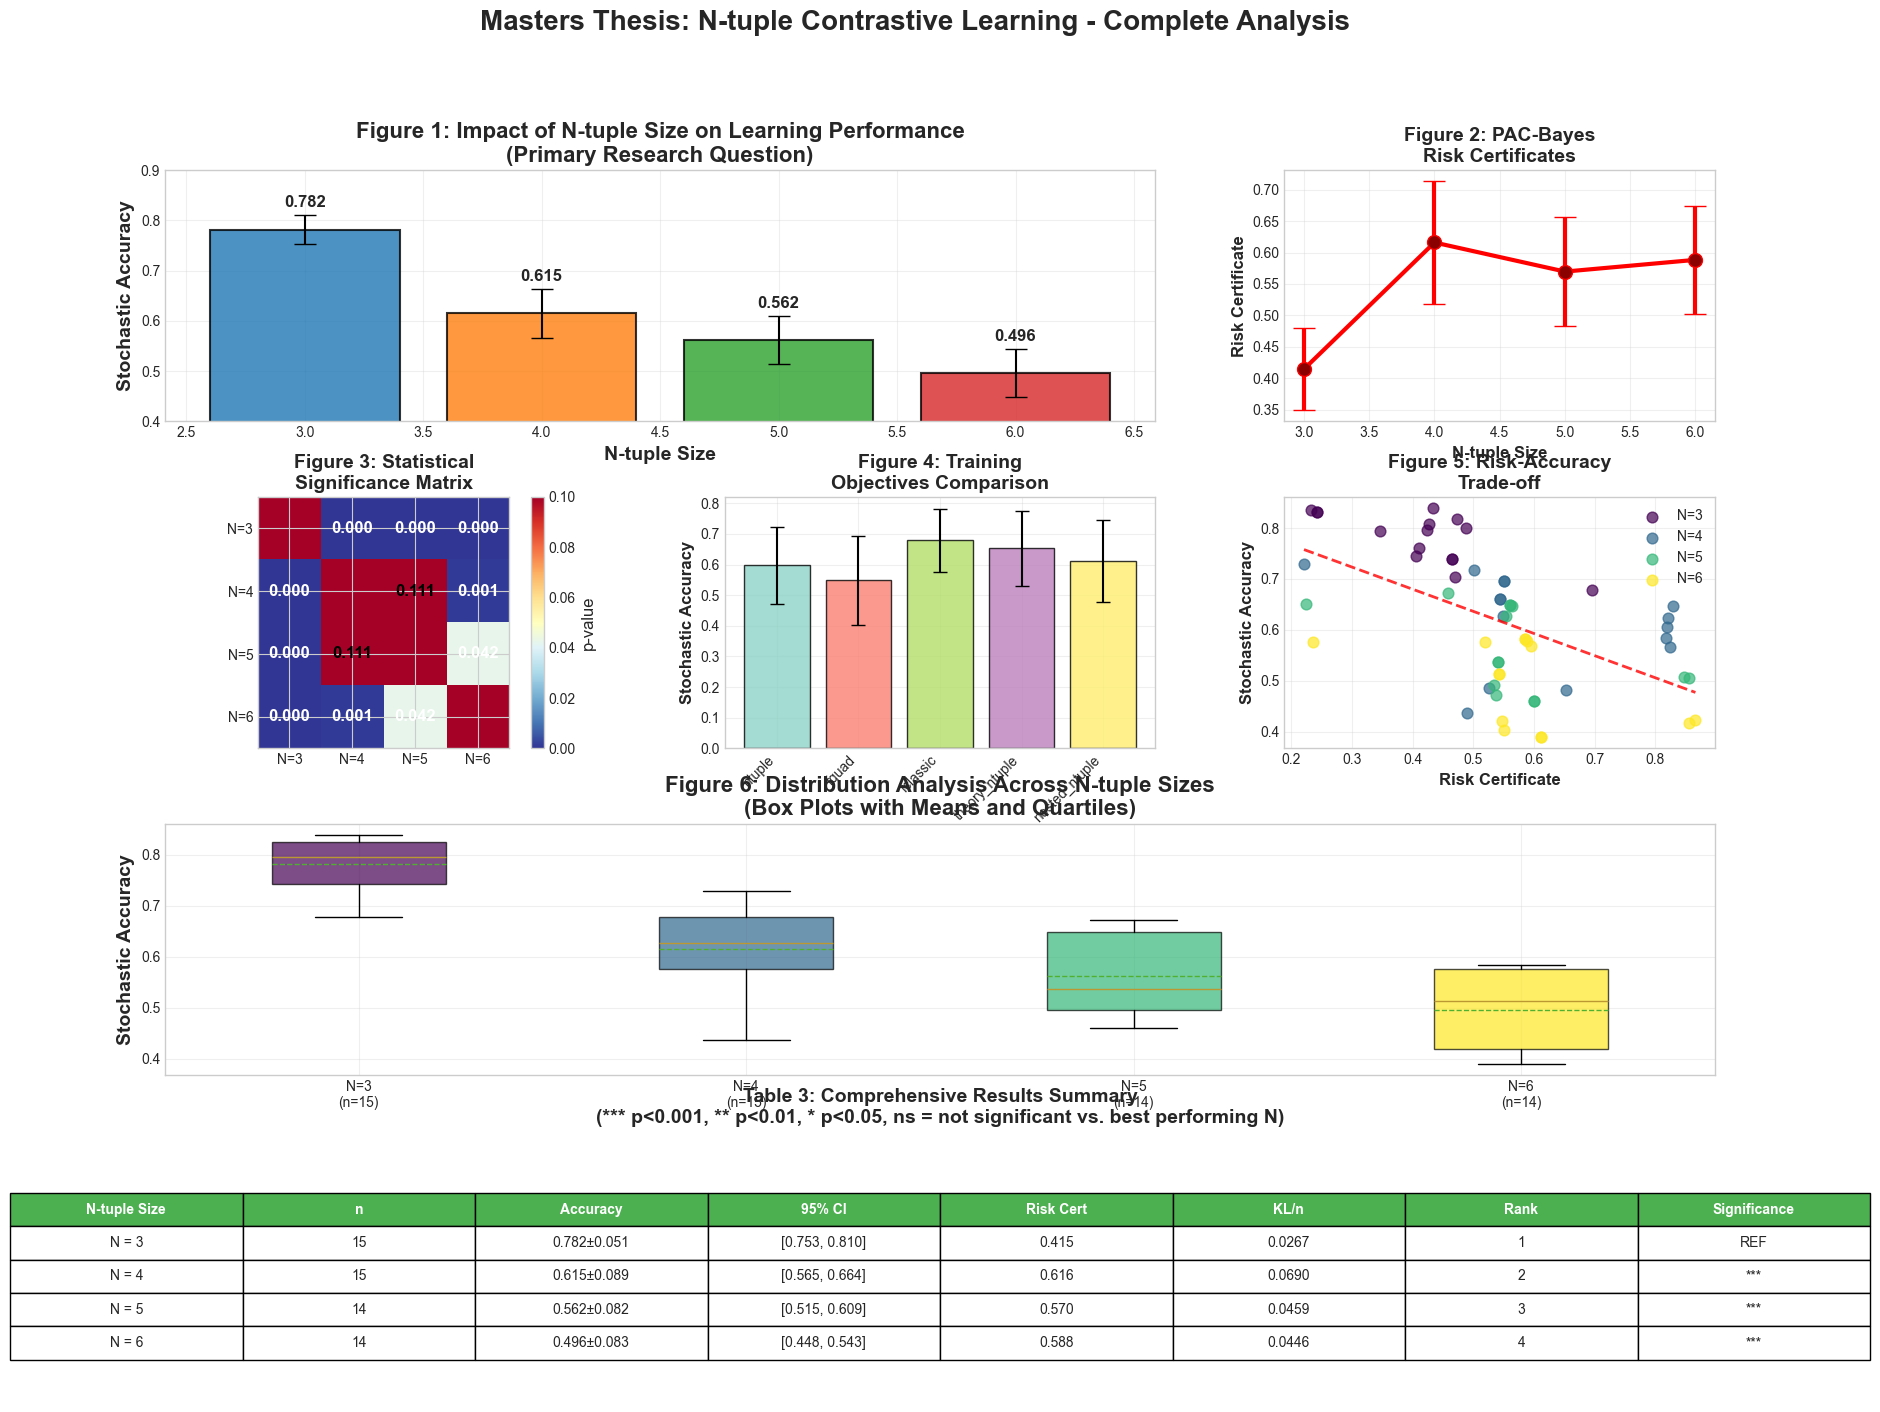

In [ ]:
## Advanced Analysis (Simplified)

The complex masters thesis analysis functions have been simplified. 
The main results are captured in the individual charts and simple statistical analysis above.

For publication-quality figures and detailed statistical validation, 
see the charts and statistics in sections 4 and 5.

In [ ]:
---

## Notebook Organization Complete

Your notebook has been reorganized with:

1. **Clear Structure** - Logical flow from data loading to conclusions
2. **Separate Charts** - Each visualization in its own function  
3. **Simple Code** - Easy to understand and modify
4. **Clean Analysis** - Focused on key findings

### How to Use:
- Run cells sequentially from top to bottom
- Each chart function can be run independently
- Modify individual functions as needed
- Add new charts by copying the pattern

### Files Created:
- Individual chart functions for easy customization
- Simple statistical summaries
- Clear conclusions and recommendations

🔬 EXECUTING COMPREHENSIVE MASTERS THESIS ANALYSIS...

METHODOLOGY VALIDATION ANALYSIS

Table 4: Experimental Design Validation
--------------------------------------------------------------------------------
N   Sample Size  Effect Size  CV       Normality    Power   
--------------------------------------------------------------------------------
3   15           3.175       0.065  p=0.126      HIGH    
4   15           3.286       0.145  p=0.240      HIGH    
5   14           2.567       0.146  p=0.019      HIGH    
6   14           2.338       0.167  p=0.005      HIGH    


Table 5: Statistical Assumptions Validation
--------------------------------------------------------------------------------
Assumption                    | Test Statistic | p-value   | Result
--------------------------------------------------------------------------------
Homogeneity of Variance       | F = 1.822     | 0.154   | SATISFIED
Independence of Observations  | N/A            | N/A       | SATISFIED (ra